In [1]:
%matplotlib inline
import time
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/final_data.csv')

In [3]:
df = df[pd.notnull(df['Tweet'])]

In [4]:
col = ['Category', 'Tweet']
df = df[col]

In [5]:
df.columns = ['Category', 'Tweet']

In [6]:
df['category_id'] = df['Category'].factorize()[0]
from io import StringIO
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

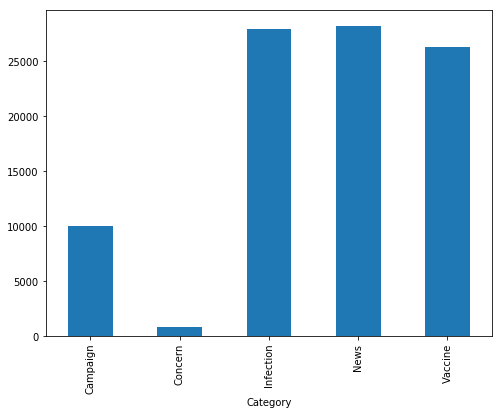

In [7]:
fig = plt.figure(figsize=(8,6))
df.groupby('Category').Tweet.count().plot.bar(ylim=0,facecolor=None, edgecolor=None)
plt.savefig('plot/categories.jpg')
plt.show()

In [8]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Tweet).toarray()
labels = df.category_id
features.shape

(93170, 19926)

In [9]:
N = 4
for Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Campaign':
  . Most correlated unigrams:
       . help
       . uk
       . campaign
       . support
  . Most correlated bigrams:
       . biking miles
       . need help
       . support meningitis
       . meningitis uk
# 'Concern':
  . Most correlated unigrams:
       . fear
       . worry
       . worried
       . scared
  . Most correlated bigrams:
       . afraid meningitis
       . meningitis scared
       . worried meningitis
       . scared meningitis
# 'Infection':
  . Most correlated unigrams:
       . shot
       . think
       . got
       . outbreak
  . Most correlated bigrams:
       . meningitis shot
       . think meningitis
       . meningitis outbreak
       . got meningitis
# 'News':
  . Most correlated unigrams:
       . fungal
       . linked
       . pharmacy
       . outbreak
  . Most correlated bigrams:
       . linked meningitis
       . deadly meningitis
       . fungal meningitis
       . meningitis outbreak
# 'Vaccine':
  . Most correlated unigrams:
   

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['Tweet'], df['Category'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [11]:
print(clf.predict(count_vect.transform(["meningitis outbreak"])))

['News']


In [12]:
start = time.time()

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MLPClassifier(),
    #MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
print("Execution time =  {}".format(time.time()-start))

Execution time =  9805.403541088104


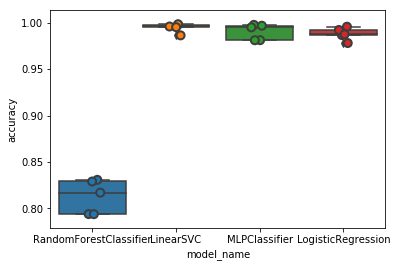

In [13]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
#plt.show()
plt.savefig('plot/count/models.jpg')

In [14]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.994891
LogisticRegression        0.988183
MLPClassifier             0.990512
RandomForestClassifier    0.812901
Name: accuracy, dtype: float64

## Support Vector Machine

In [15]:
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

              precision    recall  f1-score   support

   Infection       1.00      1.00      1.00      9122
     Concern       1.00      0.98      0.99       294
     Vaccine       1.00      1.00      1.00      9258
    Campaign       1.00      1.00      1.00      3340
        News       1.00      1.00      1.00      8733

   micro avg       1.00      1.00      1.00     30747
   macro avg       1.00      1.00      1.00     30747
weighted avg       1.00      1.00      1.00     30747



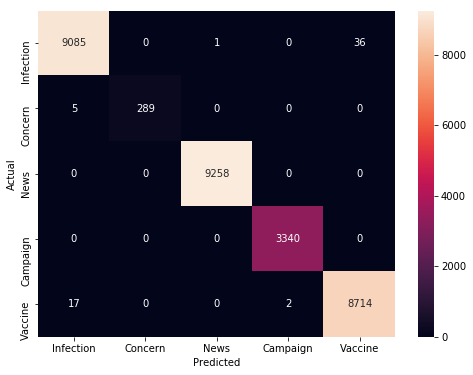

In [18]:
from sklearn.metrics import classification_report

conf_mat = confusion_matrix(y_test, y_pred)

target_names=['Infection','Concern','Vaccine','Campaign','News']
print(classification_report(y_test, y_pred, target_names=target_names))

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('plot/count/svm.jpg')
plt.show()

## ANN

In [19]:
model_ann = MLPClassifier()
model_ann.fit(X_train, y_train)
y_pred = model_ann.predict(X_test)

              precision    recall  f1-score   support

   Infection       0.99      1.00      0.99      9122
     Concern       1.00      0.96      0.98       294
     Vaccine       1.00      1.00      1.00      9258
    Campaign       1.00      1.00      1.00      3340
        News       1.00      1.00      1.00      8733

   micro avg       1.00      1.00      1.00     30747
   macro avg       1.00      0.99      0.99     30747
weighted avg       1.00      1.00      1.00     30747



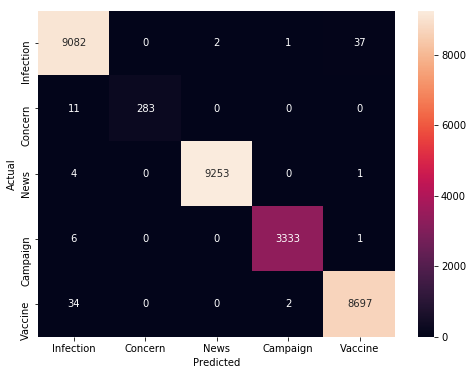

In [21]:
from sklearn.metrics import classification_report

conf_mat = confusion_matrix(y_test, y_pred)

target_names=['Infection','Concern','Vaccine','Campaign','News']
print(classification_report(y_test, y_pred, target_names=target_names))


fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('plot/count/ann.jpg')
plt.show()

## Random Forest

In [22]:
model_rf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)

model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)

              precision    recall  f1-score   support

   Infection       0.59      0.98      0.74      9122
     Concern       0.00      0.00      0.00       294
     Vaccine       0.97      0.99      0.98      9258
    Campaign       1.00      0.09      0.16      3340
        News       0.97      0.67      0.79      8733

   micro avg       0.79      0.79      0.79     30747
   macro avg       0.71      0.54      0.53     30747
weighted avg       0.85      0.79      0.76     30747



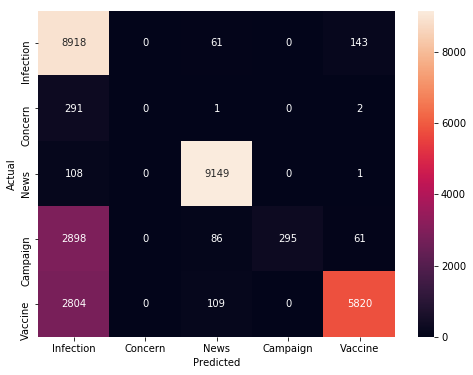

In [23]:
from sklearn.metrics import classification_report

conf_mat = confusion_matrix(y_test, y_pred)

target_names=['Infection','Concern','Vaccine','Campaign','News']
print(classification_report(y_test, y_pred, target_names=target_names))


fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('plot/count/rf.jpg')
plt.show()

## Logistic Regression

In [24]:
model_lr =  LogisticRegression(random_state=0)
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)

              precision    recall  f1-score   support

   Infection       0.98      0.99      0.99      9122
     Concern       1.00      0.55      0.71       294
     Vaccine       1.00      1.00      1.00      9258
    Campaign       1.00      0.99      1.00      3340
        News       0.99      1.00      0.99      8733

   micro avg       0.99      0.99      0.99     30747
   macro avg       0.99      0.91      0.94     30747
weighted avg       0.99      0.99      0.99     30747



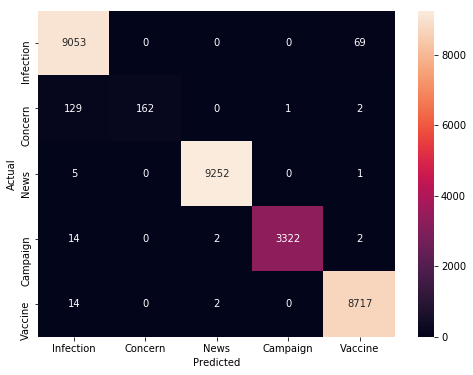

In [25]:
from sklearn.metrics import classification_report

conf_mat = confusion_matrix(y_test, y_pred)

target_names=['Infection','Concern','Vaccine','Campaign','News']
print(classification_report(y_test, y_pred, target_names=target_names))

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('plot/count/lr.jpg')
plt.show()